# IBM Circuit function

<Admonition type="note">
  Qiskit Functionsは、IBM Quantum™ Premium Plan ユーザーのみが利用できる実験的な機能です。プレビュー リリースの状態であり、変更される可能性があります。
</Admonition>

## 概要

IBM® Circuit functionは、[抽象化された PUBs](./primitive-input-output)を入力として受け取り、緩和された期待値を出力として返します。この Circuit functionには、研究者がアルゴリズムとアプリケーションの発見に集中できるように、自動化されカスタマイズされたパイプラインが含まれています。



## 説明

PUB を送信すると、抽象化された回路とオブザーバブルが自動的にトランスパイルされ、ハードウェア上で実行され、後処理されて緩和された期待値が返されます。これを行うには、次のツールを組み合わせます：


*   [Qiskit Transpiler Service](./qiskit-transpiler-service)：抽象的な回路を[ハードウェアに最適化された ISA 回路](/guides/optimize-for-hardware)に変換するための AI 駆動型およびヒューリスティックなトランスパイル パスの自動選択が含まれます。

*   [ユーティリティ・スケールの計算に必要なエラー抑制と緩和](./error-mitigation-and-suppression-techniques) ：測定とゲートのトワリング、動的デカップリング、トワリング読み出しエラー消滅（TREX）、ゼロ・ノイズ外挿（ZNE）、確率的エラー増幅（PEA）などを含む

*   [Qiskit Runtime Estimator](./get-started-with-primitives：)：ハードウェア上でISA PUBを実行し、緩和された期待値を返す。

  
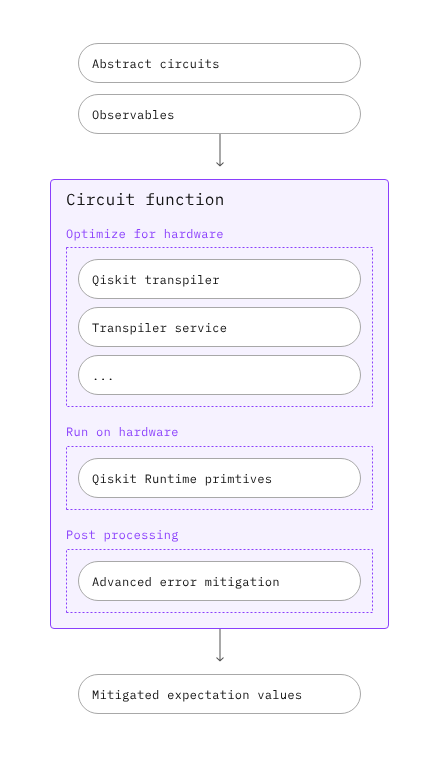

## 始めましょう


 [IBM Quantum Platform API token](http://quantum.ibm.com/)を使用して認証し、次のように Qiskit Functionを選択します。

In [1]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog

catalog = QiskitFunctionsCatalog()
function = catalog.load("ibm/circuit-function")

## 例
まず、次の基本的な例を試してください。

In [2]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService

# You can skip this step if you have a target backend, e.g.
# backend_name = "ibm_sherbrooke"
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

circuit = random_circuit(num_qubits=2, depth=2, seed=42)
observable = "Z" * circuit.num_qubits
pubs = [(circuit, observable)]

job = function.run(
  backend_name=backend.name,  # Or `backend=backend_name`, if you didn't initialize a backend object
  pubs=pubs
)

Qiskit Functionワークロードの[status](/guides/functions#check-job-status) を確認するか、次のように[results](/guides/functions#retrieve-results)を返します。


In [4]:
print(job.status())

DONE


In [5]:
result = job.result()

DONE


結果は[Estimator result](https://docs.quantum.ibm.com/guides/primitive-input-output#estimator-output)と同じ形式になります。


In [6]:
print(f'The result of the submitted job had {len(result)} PUB\n')
print(f'The associated PubResult of this job has the following DataBins:\n {result[0].data}\n')
print(f'And this DataBin has attributes: {result[0].data.keys()}')
print(f'The expectation values measured from this PUB are: \n{result[0].data.evs}')

The result of the submitted job had 1 PUB

The associated PubResult of this job has the following DataBins:
 DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>))

And this DataBin has attributes: dict_keys(['evs', 'stds', 'ensemble_standard_error'])
The expectation values measured from this PUB are: 
0.961499493414387


## 入力
IBM Circuit functionが受け入れるすべての入力パラメーターについては、次の表を参照してください。後続の[Options](#options)セクションでは、使用可能な`options` についてさらに詳しく説明します。



| Name      | Type                       | Description                                                                                                                                                                                                                         | Required | Default                                                                  | Example                                  |
|-----------|----------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|--------------------------------------------------------------------------|------------------------------------------|
| backend\_name   | str                        | Name of the backend to make the query.                                                                                                                                                                                              | Yes      | N/A                                                                      | `ibm_fez`                                |
| pubs      | Iterable\[EstimatorPubLike] |  (circuit,observables)や(circuit,observables,parameter_values)のような抽象的なPUBのような(プリミティブな統一ブロック)オブジェクトの反復可能。詳しくは[Overview of PUBs](/guides/primitive-input-output#overview-of-pubs) を参照してください。回路は抽象（非ISA）であってもよい。| Yes      | N/A                                                                      | (circuit, observables, parameter\_values) |
| options   | dict                       | Input options. See the **Options** section for more details.                                                                                                                                                                                | No       | See the **Options** section for details.                                                   | `{"optimization_level": 3}`                |
| instance  | str                        | The hub/group/project to use in that format.                                                                                                                                                                                        | No       | あなたのアカウントが複数のインスタンスにアクセスできる場合、1つがランダムに選ばれる。 | `hub1/group1/project1`                   |


### Options

#### 構造
Qiskit Runtime primitivesと同様に、IBM Circuit functionのオプションはネストされた辞書として指定できます。`optimization_level` や `mitigation_level`などのよく使用されるオプションは 第1 レベルにあります。 その他のより高度なオプションは、`resilience` などのさまざまなカテゴリにグループ化されていますresilience。


#### デフォルト
オプションの値を指定しない場合は、サービスによって指定されたデフォルト値が使用されます。


#### 緩和レベル

IBM Circuit functionは `mitigation_level`もサポートします。mitigation levelは、ジョブに適用するエラー抑制と軽減の量を指定します。レベルが高いほど、処理時間が長くなりますが、より正確な結果が生成されます。エラー削減の度合いは、適用される方法によって異なります。軽減レベルは、エラー軽減および抑制方法の詳細な選択を抽象化して、ユーザーがアプリケーションに適したコストと精度のトレードオフを判断できるようにします。次の表は、各レベルに対応する方法を示しています。


<Admonition type="note">
  名前は似ていますが、Estimatorの `resilience_level`は`mitigation_level`で使用されるものとは異なる手法が適用されます。
</Admonition>

</br></br>

Qiskit Runtime Estimatorの `resilience_level` と同様に、`mitigation_level`は基本的な緩和オプションを指定します。mitigation levelに加えて手動で指定したオプションは、mitigation levelで定義された基本オプションセットの上に適用されます。したがって、原理的には、mitigation levelを 1 に設定し、測定mitigationをオフにすることもできますが、これはお勧めしません。

| **Mitigation Level** | **Technique** |
|:-:|:-:|
| 1 \[Default] | Dynamical decoupling + 測定twirling + TREX  |
| 2 | Level 1 + gate twirling + ゲート折りたたみによるZNE |
| 3 | Level 1 + gate twirling + PEAによるZNE  |

次の例は、緩和レベルの設定を示しています：


In [7]:
options = {"mitigation_level": 2}

job = function.run(
  backend_name=backend.name,
  pubs=pubs,
  options=options
)

#### 利用可能なすべてのオプション
`mitigation_level`に加えて、IBM Circuit functionには、コストと精度のトレードオフを微調整できるいくつかの高度なオプションも用意されています。次の表に、使用可能なすべてのオプションを示します：



| Option | Sub-option | Sub-sub-option | Description | Choices | Default |
|-|-|-|-|-|-|
| default\_precision |  |  | The default precision to use for any PUB or `run()`<br />call that does not specify one.<br />Each input PUB can specify its own precision. If the `run()` method is given a precision, then that value is used for all PUBs in the `run()` call that do not specify their own.  | float > 0 | 0.015625 |
| max\_execution\_time |  |  | Maximum execution time in seconds, which is based<br />on QPU usage (not wall clock time). QPU usage is the<br />amount of time that the QPU is dedicated to processing your job. If a job exceeds this time limit, it is forcibly canceled. | Integer number of seconds in the range \[1, 10800] |  |
| mitigation\_level |  |  | How much error suppression and mitigation to apply. Refer to the [Mitigation level](#mitigation-level) section for more information about the methods used at each level. | 1 / 2 / 3 | 1 |
| optimization\_level |  |  | How much optimization to perform on the circuits. [Higher levels](/guides/set-optimization) generate more optimized circuits, at the expense of longer transpilation time. | 0 / 1 / 2 / 3 | 2 |
| dynamical\_decoupling | enable |  | Whether to enable dynamical decoupling. Refer to [Error suppression and mitigation techniques](/guides/error-mitigation-and-suppression-techniques#dynamical-decoupling) for the explanation of the method.  | True/False | True |
|  | sequence\_type |  | Which dynamical decoupling sequence to use.<br />\* `XX`: use the sequence `tau/2 - (+X) - tau - (+X) - tau/2`<br />\* `XpXm`: use the sequence `tau/2 - (+X) - tau - (-X) - tau/2`<br />\* `XY4`: use the sequence<br />`tau/2 - (+X) - tau - (+Y) - tau (-X) - tau - (-Y) - tau/2` | 'XX'/'XpXm'/'XY4' | 'XX' |
| twirling | enable\_gates |  | Whether to apply 2-qubit Clifford gate twirling. | True/False | False |
|  | enable\_measure |  | Whether to enable twirling of measurements. | True/False | True |
| resilience | measure\_mitigation |  | Whether to enable TREX measurement error mitigation method. Refer to [Error suppression and mitigation techniques](/guides/error-mitigation-and-suppression-techniques#twirled-readout-error-extinction-trex) for the explanation of the method.  | True/False | True |
|  | zne\_mitigation |  | Whether to turn on Zero Noise Extrapolation error mitigation method. Refer to [Error suppression and mitigation techniques](/guides/error-mitigation-and-suppression-techniques#zero-noise-extrapolation-zne) for the explanation of the method.  | True/False | False |
|  | zne | amplifier | Which technique to use for amplifying noise. One of: <br /> - `gate_folding` (default) uses 2-qubit gate folding to amplify noise. If the noise factor requires amplifying only a subset of the gates, then these gates are chosen randomly.<br /><br /> - `gate_folding_front` uses 2-qubit gate folding to amplify noise. If the noise factor requires amplifying only a subset of the gates, then these gates are selected from the front of the topologically ordered DAG circuit.<br /><br /> - `gate_folding_back` uses 2-qubit gate folding to amplify noise. If the noise factor requires amplifying only a subset of the gates, then these gates are selected from the back of the topologically ordered DAG circuit.<br /><br /> - `pea` uses a technique called Probabilistic error amplification (PEA) to amplify noise. Refer to [Error suppression and mitigation techniques](/guides/error-mitigation-and-suppression-techniques#probabilistic-error-amplification-pea) for the explanation of the method.  | gate\_folding / gate\_folding\_front / gate\_folding\_back / pea | gate\_folding |
|  |  | noise\_factors | Noise factors to use for noise amplification. | list of floats; each float >= 1 | (1, 1.5, 2) for PEA, and (1, 3, 5) otherwise. |
|  |  | extrapolator | Noise factors to evaluate the fit extrapolation models at. This option does not affect execution or model fitting in any way; it only determines the points at which the `extrapolator`s are evaluated to be returned in the data fields called `evs_extrapolated` and `stds_extrapolated`. | one or more of `exponential`,`linear`, `double_exponential`,`polynomial_degree_(1 <= k <= 7)` | (`exponential`, `linear`) |
|  | pec\_mitigation |  | Whether to turn on Probabilistic Error Cancellation error mitigation method. Refer to [Error suppression and mitigation techniques](/guides/error-mitigation-and-suppression-techniques#probabilistic-error-cancellation-pec) for the explanation of the method.  | True/False | False |
|  | pec | max\_overhead | The maximum circuit sampling overhead allowed, or `None` for no maximum. | None/ integer >1 | 100 |

次の例では、mitigation level を 1 に設定すると、最初は ZNE 緩和がオフになりますが、`zne_mitigation`を`True`に設定すると、`mitigation_level`からの関連設定が上書きされます。

In [8]:
options = {
  "mitigation_level": 1,
  "resilience": {"zne_mitigation": True}
}

## 出力


Circuit functionの出力は[PrimitiveResult](/api/qiskit/qiskit.primitives.PrimitiveResult)であり、これには次の 2 つのフィールドが含まれます：

*   1 つ以上の[PubResult](/api/qiskit/qiskit.primitives.PubResult)オブジェクト。これらは`PrimitiveResult`から直接インデックス付けできます。

*   ジョブレベルのメタデータ。

それぞれの`PubResult`に `data` と `metadata` フィールドが含まれます。

*   この `data` フィールドには、少なくとも期待値の配列 (`PubResult.data.evs`)  と標準誤差の配列 (`PubResult.data.stds`)が含まれます。また、使用するオプションに応じて、さらに多くのデータが含まれる場合もあります。

*  この`metadata`フィールドには PUB レベルのメタデータ (`PubResult.metadata`) が含まれます。

次のコード スニペットは、`PrimitiveResult` (および関連する`PubResult`) 形式について説明します。


In [9]:
print(f'The result of the submitted job had {len(result)} PUB')
print(f'The expectation values measured from this PUB are: \n{result[0].data.evs}')
print(f'And the associated metadata is: \n{result[0].metadata}')

The result of the submitted job had 1 PUB
The expectation values measured from this PUB are: 
0.961499493414387
And the associated metadata is: 
{'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


## エラーメッセージの取得
ワークロードのステータスが  `ERROR`の場合、`job.result()`で、デバッグに役立つエラー メッセージを取得します：



In [8]:
job = function.run(
  backend_name="bad_backend_name",
  pubs=pubs,
  options=options
)

print(job.result())

Traceback (most recent call last):
  File "/runner/runner.py", line 10, in run
    func = CircuitFunction(**arguments)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/runner/circuit_function/circuit_function.py", line 86, in __init__
    self._backend = self._service.backend(
                    ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py", line 787, in backend
    backends = self.backends(name, instance=instance, use_fractional_gates=use_fractional_gates)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py", line 536, in backends
    raise QiskitBackendNotFoundError("No backend matches the criteria.")
qiskit.providers.exceptions.QiskitBackendNotFoundError: 'No backend matches the criteria.'



## サポートを受ける

[IBM Quantum support](https://docs.quantum.ibm.com/support)に連絡し、次の情報を伝えてください。



*   Qiskit Function Job ID (`qiskit-ibm-catalog`), `job.job_id`

*   問題の詳細な説明

*   関連するエラーメッセージまたはコード
   
*   問題を再現する手順


## 次のステップ

<Admonition type="tip" title="Recommendations">
 * [IBM Circuit functionを使用したワークフローの構築](https://learning.quantum.ibm.com/tutorial/building-workflows-with-the-ibm-circuit-function)チュートリアルをお試しください。
</Admonition>
